# ResNet-18 usando PyTorch Lightning
## Objetivos

- Importar un modelo CNN complejo
- Entrenar el modelo para clasificacion de imagenes


## Instalar e importar bibliotecas


In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pandas as pd


import torch.optim as optim
from torchmetrics import Accuracy
from torchvision import datasets, transforms, models

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
import torchmetrics

from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
from collections import Counter
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar


In [2]:
BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
NUM_WORKERS = 40
CLASES = 10

In [3]:
DEBUG_MODE = False  # True Debug, False Full
 
if DEBUG_MODE:
    BATCH_SIZE = 4
    NUM_EPOCHS = 2
    print("Modo depuración activado: usando dataset ligero y parámetros reducidos.")
else:
    BATCH_SIZE = 32
    NUM_EPOCHS = 100
    print("Modo completo activado: usando configuración completa.")
 

Modo completo activado: usando configuración completa.


## Preparación de la base de datos:

### Fashion MNIST contiene 60k RGB imágenes de 32x32x3 pixeles distribuidas en 10 clases.

*   Grupo de entrenamiento: 50K imágenes
*   Grupo de evaluación: 10k imágenes

In [4]:
# Descargamos dataset
 
if DEBUG_MODE:
    train_dataset = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=transforms.ToTensor(), download=True)
 
    test_dataset = datasets.FashionMNIST(
        root="./data", train=False, transform=transforms.ToTensor(), download=True)
else:
    train_dataset = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=transforms.ToTensor(), download=True)
 
    test_dataset = datasets.FashionMNIST(
        root="./data", train=False, transform=transforms.ToTensor(), download=True)

In [5]:
# Definimos dataloaders para los datasets

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          drop_last=False, # ignora el último batch si el número de muestras no son divisibles para el tamaño de batch
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          drop_last=False,
                          shuffle=False)

In [6]:
print("Número de muestras de entrenamiento:", len(train_dataset))
print("Número de muestras de evaluación:", len(test_dataset))


Número de muestras de entrenamiento: 60000
Número de muestras de evaluación: 10000


In [7]:
print("Número de iteraciones por época:", len(train_loader))
# 1563*32 = 50000
# 3152*16 = 50000

Número de iteraciones por época: 1875


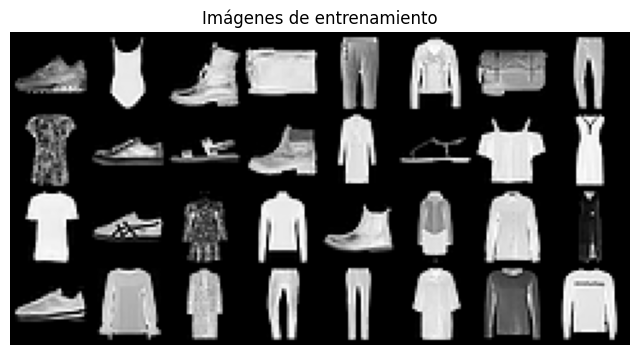

In [8]:
# Visualización de imágenes

for images, labels in train_loader:
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Imágenes de entrenamiento")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64],
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

In [9]:
# Dimensión de cada imagen
print("Dimensión de entrada:", images.shape) # (batch_size, channels_in, W, H)

Dimensión de entrada: torch.Size([32, 1, 28, 28])


In [10]:
class FMNIST_DataModule(pl.LightningDataModule):
    def __init__(self, data_path="./", batch_size=64, num_workers=223):
        super().__init__()
        self.data_path = data_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = torch.cuda.is_available()

        self.train_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(30),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485]*3, std=[0.229]*3)
        ])

        self.test_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485]*3, std=[0.229]*3)
        ])

    def prepare_data(self):
        # Descarga si es que no se ha descargado todavia.
        # datasets.FashionMNIST(root=self.data_path, train=True, download=True)
        # datasets.FashionMNIST(root=self.data_path, train=False, download=True)
        pass

    def setup(self, stage=None):
        if stage in (None, "fit"):
            train_full = datasets.FashionMNIST(
                root=self.data_path, train=True, transform=self.train_transform, download=False
            )
            n_total = len(train_full)
            n_val = int(0.1 * n_total)
            n_train = n_total - n_val
            g = torch.Generator().manual_seed(42)  # split reproducible
            self.train, self.valid = random_split(train_full, lengths=[n_train, n_val], generator=g)

        if stage in (None, "test"):
            self.test = datasets.FashionMNIST(
                root=self.data_path, train=False, transform=self.test_transform, download=False
            )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            persistent_workers=(self.num_workers > 0),
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.valid,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            persistent_workers=(self.num_workers > 0),
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            persistent_workers=(self.num_workers > 0),
        )


In [11]:
# Inicizalización de DataModule

torch.manual_seed(47)  # especificamos un random seed para reproducibilidad de inicializaciones aleatorias
data_module = FMNIST_DataModule(data_path='./data')

In [12]:
# Inicialización del modulo lightning

callback_check = ModelCheckpoint(save_top_k=1, mode="max", monitor="valid_acc") # guardamos el mejor modelo monitoreado en la acc de validación. Por qué no la de entrenamiento?

callback_tqdm = RichProgressBar(leave=True)

early_stop_callback = EarlyStopping(
    monitor='valid_loss', # Monitoreamos la métrica de validación
    min_delta=0.00, # Cambio mínimo para calificar como mejora
    patience=10, # Número de épocas sin mejora después de las cuales se detendrá el entrenamiento
    verbose=True, # Imprimir mensajes al detenerse
    mode='min' # Dirección de mejora ('min' para pérdida, 'max' para precisión)
)

logger = CSVLogger(save_dir="logs/", name="complex-cnn-fmnist")

In [13]:
class ResNet18TransferLearning(pl.LightningModule):
    def __init__(self, num_classes=10, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
 
        # Utilizamos ResNet18 pre-entrenada
        self.model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
 
        # Reemplazamos la ultima capa de clasificación para ajustar al numero de clases
        # de nuestro dataset (FMNIST)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.fc.parameters():
            param.requires_grad = True
 
        # Definimos criterio de Loss y Accuracy
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.test_acc = Accuracy(task='multiclass', num_classes=num_classes)
 
    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch, stage):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = logits.argmax(1)
        out = (loss, y, preds)
        return out
    
    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch, stage="train")
        acc = self.accuracy(predicted_labels, true_labels)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        return loss
 
    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch, stage="valid")
        acc = self.accuracy(predicted_labels, true_labels)
        self.log('valid_loss', loss, prog_bar=True)
        self.log('valid_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch, stage="test")
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)
 
    def configure_optimizers(self):
        return optim.Adam(self.model.fc.parameters(), lr=self.hparams.learning_rate)
        # Solo hacemos ajuste fino sobre el clasificador

In [ ]:
# Instantiate model
pytorch_model = ResNet18TransferLearning(num_classes=10, learning_rate=1e-3)

# Trainer
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices='auto',
    log_every_n_steps=10,
    logger=logger,
    callbacks=[callback_check, callback_tqdm, early_stop_callback]
)

# Train
trainer.fit(pytorch_model, datamodule=data_module )


start_time = time.time()

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ ResNet             │ 11.2 M │ train │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │ train │
│ 2 │ accuracy  │ MulticlassAccuracy │      0 │ train │
│ 3 │ test_acc  │ MulticlassAccuracy │      0 │ train │
└───┴───────────┴────────────────────┴────────┴───────┘

Trainable params: 5.1 K                                                                                            
Non-trainable params: 11.2 M                                                                                       
Total params: 11.2 M                                                                                               
Total estimated model params size (MB): 44                                                                         
Modules in train mode: 71                                                                                          
Modules in eval mode: 0

Output()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will 
create 223 worker processes in total. Our suggested max number of worker in current system is 40, which is smaller 
than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader 
running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved. New best score: 0.776


Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.056 >= min_delta = 0.0. New best score: 0.720


Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.694


Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.682


Output()

## Graficamos las curvas de aprendizaje del modelo

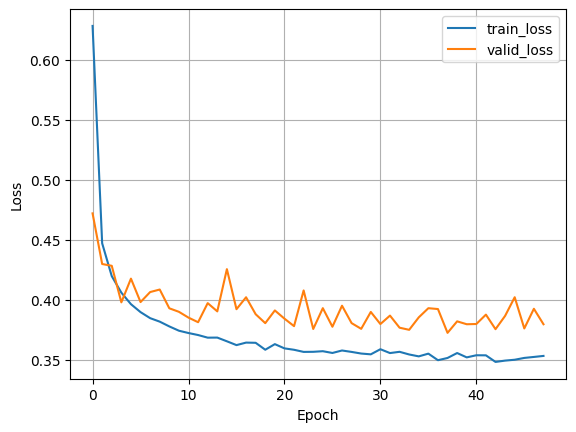

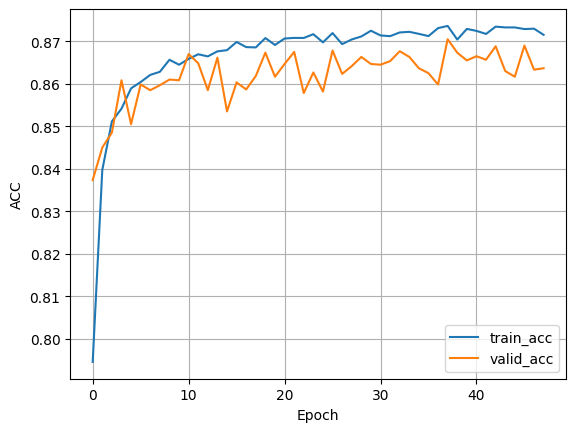

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

## Evaluamos el mejor modelo en el grupo de test

In [ ]:
trainer.test(model = pytorch_model, datamodule = data_module, ckpt_path = 'best') # cargamos el mejor checkpoint del modelo

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/complex-cnn-fmnist/version_22/checkpoints/epoch=37-step=32034.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/complex-cnn-fmnist/version_22/checkpoints/epoch=37-step=32034.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8651999831199646     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8651999831199646}]